**This code is for training vgg 16 model for 60 epoch 20 epoch per model i.e model will be retrained by reuploading but saving with different names.**

# ***change the paths value as per your driver location for the segmented data and to save and upload the model***
1.   **Record weight(preferable screen record 'in form of video') due to large numbers**
*   need superviser guidence to put this data in report
2.   **record graph and final output accuracy 'screenshot'**

In [1]:
# Connection to google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import random
#import zipfile
import tensorflow as tf
from keras.models import Model
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Activation
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.metrics import classification_report, log_loss, accuracy_score

In [ ]:
#source path for training data
source_path='/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image'


In [ ]:
# below path is combination of paths i.e training/segmented will be added after source_path to create new path

In [ ]:
Training_DIR = os.path.join(source_path, 'training/segmented')
Validation_DIR = os.path.join(source_path, 'testing/segmented')

In [ ]:
# Use the Image Data Generator to import the images from the dataset
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rotation_range=30,
                                    zoom_range=0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.2,
                                    shear_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(Training_DIR,
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2968 images belonging to 4 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(Validation_DIR,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 600 images belonging to 4 classes.


In [3]:
pretrained_model = tf.keras.applications.VGG16(input_shape=(256,256,3),
                                                include_top=False,
                                                weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [4]:
# Get the block5_conv3 layer
block5_conv3 = pretrained_model.get_layer('block5_conv3')

# Get the weights of the layer
weights = block5_conv3.get_weights()
print(weights)
#first array is flattened value of (filter_height , filter_width , input_channels , output_channels)
#second 1 dimension array is bias value

[array([[[[ 4.07882966e-04,  4.82621184e-03, -9.11695044e-03, ...,
           1.51569908e-02, -2.73966836e-03, -4.83311387e-03],
         [ 3.48924054e-03,  2.60589737e-03, -8.10198858e-03, ...,
           8.86987546e-04, -7.08238874e-03, -7.96321197e-04],
         [-1.12759033e-02, -6.43836753e-03, -8.05236772e-03, ...,
           1.90410519e-03,  3.87627119e-03,  1.96338408e-02],
         ...,
         [-1.49949323e-02,  1.20318262e-02,  9.87236737e-04, ...,
          -2.89861043e-03,  4.03315574e-03, -5.93429338e-03],
         [-7.53336679e-03,  6.08530594e-03,  9.90014290e-04, ...,
           1.63243050e-04, -3.09621776e-03, -3.01808352e-03],
         [-2.62522907e-03,  3.51887429e-03, -2.58309790e-03, ...,
          -6.02027494e-03, -8.85035843e-03,  9.85825085e-04]],

        [[ 3.02846078e-04,  2.64736195e-03, -1.37099335e-02, ...,
           1.49135189e-02, -4.65666235e-04, -6.84898719e-03],
         [-9.60117579e-03,  5.01031429e-03, -1.13053191e-02, ...,
           8.86707660

In [5]:
# for fine tuning block5_conv3 only
# fine tuning - updating the weight and bios value for our dataset during training
layer_index = [index for index, layer in enumerate(pretrained_model.layers) if layer.name == "block5_conv3"][0]
layer = pretrained_model.layers[layer_index]

for i, layer in enumerate(pretrained_model.layers):
    if i == layer_index:
        layer.trainable = True
    else:
        layer.trainable = False

In [6]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# adding dense layer to train the model
inputs = pretrained_model.input
x = tf.keras.layers.Flatten()(pretrained_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

# create a model object
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# training rate used in vgg16 0.001
# tell the model what cost and optimization method to use

from tensorflow.keras.callbacks import ReduceLROnPlateau
#  the learning rate will be reduced by a factor of 0.1 if the validation loss does not improve after 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

from keras.callbacks import EarlyStopping
# Define a callback that stops training when the accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, min_delta=0.001, mode='max')

#since learning rate was not defined so default for adam will be used i.e 0.001
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
train = model.fit(training_set,
                validation_data = test_set, 
                epochs = 200, 
                steps_per_epoch = len(training_set),
                validation_steps = len(test_set),
                callbacks=[reduce_lr, early_stopping]
                )


Epoch 1/200
93/93 [==============================] - 1595s 17s/step - loss: 1.2994 - accuracy: 0.5768 - val_loss: 1.4665 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/200
93/93 [==============================] - 54s 581ms/step - loss: 0.8665 - accuracy: 0.6728 - val_loss: 2.9015 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 3/200
93/93 [==============================] - 54s 582ms/step - loss: 0.7623 - accuracy: 0.7126 - val_loss: 1.0095 - val_accuracy: 0.5383 - lr: 0.0010
Epoch 4/200
93/93 [==============================] - 54s 583ms/step - loss: 0.6908 - accuracy: 0.7382 - val_loss: 0.7652 - val_accuracy: 0.6433 - lr: 0.0010
Epoch 5/200
93/93 [==============================] - 54s 580ms/step - loss: 0.6452 - accuracy: 0.7642 - val_loss: 0.8617 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 6/200
93/93 [==============================] - 54s 583ms/step - loss: 0.6094 - accuracy: 0.7790 - val_loss: 1.4334 - val_accuracy: 0.6233 - lr: 0.0010
Epoch 7/200
93/93 [==============================] - 54s 5

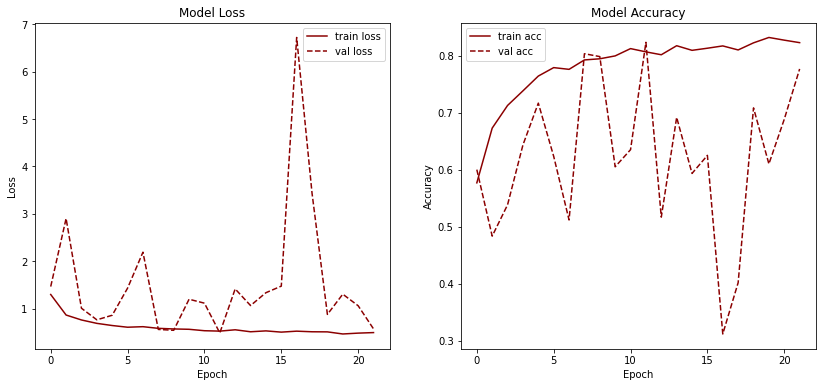

In [ ]:
# plot the loss
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
plt.plot(train.history['loss'], label='train loss', color = 'darkred')
plt.plot(train.history['val_loss'], label='val loss',linestyle='--', color = 'darkred')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.show()


plt.subplot(1,2,2)
# plot the accuracy
plt.plot(train.history['accuracy'], label='train acc', color = 'darkred')
plt.plot(train.history['val_accuracy'], label='val acc', linestyle='--', color = 'darkred')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
print("Final Train Accuracy:", train.history['accuracy'][-1])
print("Final Test Accuracy:", train.history['val_accuracy'][-1])
print("Final Train Loss:", train.history['loss'][-1])
print("Final Test Loss:", train.history['val_loss'][-1])

Final Train Accuracy: 0.8227762579917908
Final Test Accuracy: 0.7766666412353516
Final Train Loss: 0.4963303506374359
Final Test Loss: 0.5741185545921326


In [ ]:
# save it as a h5 file
tf.keras.models.save_model(model, '/content/drive/MyDrive/rice_leaf_disease/colab/models/vgg16.h5')

In [ ]:
# Get the block5_conv3 layer
block5_conv3 = pretrained_model.get_layer('block5_conv3')

# Get the weights of the layer
weights = block5_conv3.get_weights()
print(weights)

[array([[[[-7.31690275e-03, -1.25651190e-03, -1.60076302e-02, ...,
           1.74770448e-02,  8.76207487e-04, -1.03609236e-02],
         [-4.00468241e-03,  5.83280530e-03, -1.75882913e-02, ...,
           5.61208371e-03, -2.24195775e-02, -6.31363643e-03],
         [-5.35034016e-03, -1.36672624e-03,  1.83695040e-04, ...,
           6.13852218e-03,  1.01881456e-02,  1.96338408e-02],
         ...,
         [-2.07141563e-02,  9.90383141e-03, -6.53439853e-03, ...,
          -6.41653966e-03,  2.22072704e-03, -5.93429338e-03],
         [ 1.61900854e-04,  6.86221104e-03, -4.20566974e-03, ...,
           9.42668784e-03, -1.09348865e-02, -3.01808352e-03],
         [-2.62522907e-03,  3.51789198e-03,  4.16047275e-02, ...,
          -2.01848685e-03, -1.32295340e-02,  9.85825085e-04]],

        [[-7.08240550e-03, -3.06958542e-03, -1.86220612e-02, ...,
           1.61080826e-02,  1.26475329e-03, -1.23801297e-02],
         [-1.23753026e-02,  2.42362241e-03, -3.36261429e-02, ...,
           1.06495880

**Starting first retraining**

In [ ]:
#!pip install pyyaml h5py  # Required to save models in HDF5 format
from tensorflow.keras.models import load_model
path = '/content/drive/MyDrive/rice_leaf_disease/colab/models/model1.h5'
model=load_model(path)

In [ ]:
#source path for training data
source_path='/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image'

#performing shuffeling operation so that datas are different when retraining model
train_brownspot_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/training/segmented/brownspot'
train_healthy_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/training/segmented/healthy'
train_hispa_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/training/segmented/hispa'
train_leafblast_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/training/segmented/leafblast'

validating_brownspot_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/testing/segmented/brownspot'
validating_healthy_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/testing/segmented/healthy'
validating_hispa_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/testing/segmented/hispa'
validating_leafblast_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/testing/segmented/leafblast'


In [ ]:
#shuffeling images of specific folders will be performed for retraining models
files = os.listdir(train_brownspot_path)
random.shuffle(files)

files = os.listdir(train_healthy_path)
random.shuffle(files)

files = os.listdir(train_hispa_path)
random.shuffle(files)

files = os.listdir(train_leafblast_path)
random.shuffle(files)

files = os.listdir(validating_brownspot_path)
random.shuffle(files)

files = os.listdir(validating_healthy_path)
random.shuffle(files)

files = os.listdir(validating_hispa_path)
random.shuffle(files)

files = os.listdir(validating_leafblast_path)
random.shuffle(files)

Training_DIR = os.path.join(source_path, 'training/segmented')
Validation_DIR = os.path.join(source_path, 'testing/segmented')


In [ ]:
# Use the Image Data Generator to import the images from the dataset
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rotation_range=30,
                                    zoom_range=0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.2,
                                    shear_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(Training_DIR,
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

In [ ]:
test_set = test_datagen.flow_from_directory(Validation_DIR,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

In [ ]:
#training rate used in vgg16 0.001
# tell the model what cost and optimization method to use

from tensorflow.keras.callbacks import ReduceLROnPlateau
#  the learning rate will be reduced by a factor of 0.1 if the validation loss does not improve after 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#since learning rate was not defined so default for adam will be used i.e 0.001
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
train = model.fit(training_set,
                validation_data = test_set, 
                epochs = 20, 
                steps_per_epoch = len(training_set),
                validation_steps = len(test_set),
                callbacks=[reduce_lr]
                )


In [ ]:
# plot the loss
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
plt.plot(train.history['loss'], label='train loss', color = 'darkred')
plt.plot(train.history['val_loss'], label='val loss',linestyle='--', color = 'darkred')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.show()


plt.subplot(1,2,2)
# plot the accuracy
plt.plot(train.history['accuracy'], label='train acc', color = 'darkred')
plt.plot(train.history['val_accuracy'], label='val acc', linestyle='--', color = 'darkred')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
print("Final Train Accuracy:", train.history['accuracy'][-1])
print("Final Test Accuracy:", train.history['val_accuracy'][-1])
print("Final Train Loss:", train.history['loss'][-1])
print("Final Test Loss:", train.history['val_loss'][-1])

In [ ]:
# Get the block5_conv3 layer
block5_conv3 = pretrained_model.get_layer('block5_conv3')

# Get the weights of the layer
weights = block5_conv3.get_weights()
print(weights)

In [ ]:
# save it as a h5 file
tf.keras.models.save_model(model, '/content/drive/MyDrive/rice_leaf_disease/colab/models/model2.h5')

**Second retrain starts here**

In [ ]:
#!pip install pyyaml h5py  # Required to save models in HDF5 format
from tensorflow.keras.models import load_model
path = '/content/drive/MyDrive/rice_leaf_disease/colab/models/model2.h5'
model=load_model(path)

In [ ]:
#source path for training data
source_path='/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image'

#performing shuffeling operation so that datas are different when retraining model
train_brownspot_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/training/segmented/brownspot'
train_healthy_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/training/segmented/healthy'
train_hispa_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/training/segmented/hispa'
train_leafblast_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/training/segmented/leafblast'

validating_brownspot_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/testing/segmented/brownspot'
validating_healthy_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/testing/segmented/healthy'
validating_hispa_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/testing/segmented/hispa'
validating_leafblast_path = '/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image/testing/segmented/leafblast'


In [ ]:
#shuffeling images of specific folders will be performed for retraining models
files = os.listdir(train_brownspot_path)
random.shuffle(files)

files = os.listdir(train_healthy_path)
random.shuffle(files)

files = os.listdir(train_hispa_path)
random.shuffle(files)

files = os.listdir(train_leafblast_path)
random.shuffle(files)

files = os.listdir(validating_brownspot_path)
random.shuffle(files)

files = os.listdir(validating_healthy_path)
random.shuffle(files)

files = os.listdir(validating_hispa_path)
random.shuffle(files)

files = os.listdir(validating_leafblast_path)
random.shuffle(files)

Training_DIR = os.path.join(source_path, 'training/segmented')
Validation_DIR = os.path.join(source_path, 'testing/segmented')


In [ ]:
# Use the Image Data Generator to import the images from the dataset
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rotation_range=30,
                                    zoom_range=0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.2,
                                    shear_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(Training_DIR,
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

In [ ]:
test_set = test_datagen.flow_from_directory(Validation_DIR,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

In [ ]:
#training rate used in vgg16 0.001
# tell the model what cost and optimization method to use

from tensorflow.keras.callbacks import ReduceLROnPlateau
#  the learning rate will be reduced by a factor of 0.1 if the validation loss does not improve after 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#since learning rate was not defined so default for adam will be used i.e 0.001
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
train = model.fit(training_set,
                validation_data = test_set, 
                epochs = 20, 
                steps_per_epoch = len(training_set),
                validation_steps = len(test_set),
                callbacks=[reduce_lr]
                )


In [ ]:
# plot the loss
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
plt.plot(train.history['loss'], label='train loss', color = 'darkred')
plt.plot(train.history['val_loss'], label='val loss',linestyle='--', color = 'darkred')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.show()


plt.subplot(1,2,2)
# plot the accuracy
plt.plot(train.history['accuracy'], label='train acc', color = 'darkred')
plt.plot(train.history['val_accuracy'], label='val acc', linestyle='--', color = 'darkred')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
print("Final Train Accuracy:", train.history['accuracy'][-1])
print("Final Test Accuracy:", train.history['val_accuracy'][-1])
print("Final Train Loss:", train.history['loss'][-1])
print("Final Test Loss:", train.history['val_loss'][-1])

In [ ]:
# Get the block5_conv3 layer
block5_conv3 = pretrained_model.get_layer('block5_conv3')

# Get the weights of the layer
weights = block5_conv3.get_weights()
print(weights)

In [ ]:
# save it as a h5 file
tf.keras.models.save_model(model, '/content/drive/MyDrive/rice_leaf_disease/colab/models/model3.h5')